## Hartman 6d function

Source: https://www.sfu.ca/~ssurjano/hart6.html

In [1]:
import jax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from jaxopt import ProjectedGradient
from rebayes_mini.methods import low_rank_last_layer as lrll

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_palette("colorblind")

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [5]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [6]:
def hartmann6(x):
    """
    Evaluates the 6-dimensional Hartmann function at point x.
    :param x: A numpy array of shape (6,)
    :return: Function value at x
    """
    # Coefficients
    alpha = jnp.array([1.0, 1.2, 3.0, 3.2])
    A = jnp.array([
        [10, 3, 17, 3.50, 1.7, 8],
        [0.05, 10, 17, 0.1, 8, 14],
        [3, 3.5, 1.7, 10, 17, 8],
        [17, 8, 0.05, 10, 0.1, 14]
    ])
    P = 1e-4 * jnp.array([
        [1312, 1696, 5569, 124, 8283, 5886],
        [2329, 4135, 8307, 3736, 1004, 9991],
        [2348, 1451, 3522, 2883, 3047, 6650],
        [4047, 8828, 8732, 5743, 1091, 381]
    ])
    
    # Compute function value
    sum_terms = jnp.sum(A * (x - P) ** 2, axis=1)
    exp_terms = jnp.exp(-sum_terms)
    result = -jnp.sum(alpha * exp_terms)
    
    return result

# Example usage:
x_test = jnp.array([0.2, 0.4, 0.6, 0.8, 0.3, 0.5])
x_opt = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])

print(hartmann6(x_test))

-0.1961809


In [7]:
x_opt = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
print(hartmann6(x_opt))

-3.322363


## The BNN surrogate model

In [8]:
class MLP(nn.Module):
    n_hidden: int = 180

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        # x = jnp.sin(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [9]:
def projection(params, hparams):
    return jnp.clip(params, 0.0, 1.0)


def minimise_project(guess_init, params_hidden, params_ll, agent):
    fn_sampled = lambda x: -agent.mean_fn(params_hidden, params_ll, x).squeeze()
    opt = ProjectedGradient(
        fun=fn_sampled,
        projection=projection,  # Enforce boundary constraints
        stepsize=1e-5,
        tol=1e-5,
        maxiter=1000,
    )
    res = opt.run(guess_init)
    return res

def step(state, t, key, agent, guess_init=None):
    bel, x, y, y_best = state
    key_step = jax.random.fold_in(key, t)
    key_step, key_guess = jax.random.split(key_step)
    guess_init = x_test
    # guess_init = jax.random.uniform(key_step, shape=(6,), minval=0, maxval=1)

    ll_params = agent.sample_params_last_layer(key_step, bel).squeeze()
    # compute location of next best estimate and actual estimate
    x_next = minimise_project(guess_init, bel.mean_hidden, ll_params, agent).params
    y_next = -hartmann6(x_next).squeeze()
    # update belief based on true observations
    bel = agent.update(bel, y_next.squeeze(), x_next)

    y_best = y_next * (y_next > y_best) + y_best * (y_next <= y_best)

    out = {
        "x": x_next.squeeze(),
        "y": y_next.squeeze(),
        "y_best": y_best.squeeze()
    }

    state_next = (bel, x_next, y_next, y_best)
    return state_next, out

In [431]:
def orthogonal(key, n, m):
    """
    https://github.com/jax-ml/jax/blob/main/jax/_src/random.py#L2041-L2095
    """
    z = jax.random.normal(key, (max(n, m), min(n, m)))
    q, r = jnp.linalg.qr(z)
    d = jnp.linalg.diagonal(r)
    x = q * jnp.expand_dims(jnp.sign(d), -2)
    return x.T

## Optimise!

In [146]:
key = jax.random.PRNGKey(314)
key_init_params, key_init_x, key_eval = jax.random.split(key, 3)

In [168]:
surrogate = MLP()
params_init = surrogate.init(key_init_params, x_test)

def cov_fn(y): return 0.0 # Function interpolation does not require observation noise
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-3, # parameters do not vary much from their initial parameters
    cov_last=1.0 # uncertainty in target
)

In [170]:
# Is this even necesssary?
bel_init = bel_init.replace(
    loading_hidden=W * 1e-6
)

In [171]:
x_next = jax.random.uniform(key_init_x, shape=(6,), minval=0, maxval=1)
y_next = hartmann6(x_next)

In [172]:
steps = jnp.arange(100)
state_init = (bel_init, x_next, y_next, y_next)
_eval = partial(step, key=key_eval, agent=agent)
bel_final, hist = jax.lax.scan(_eval, state_init, steps)

In [173]:
x_opt = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
y_opt = -hartmann6(x_opt)

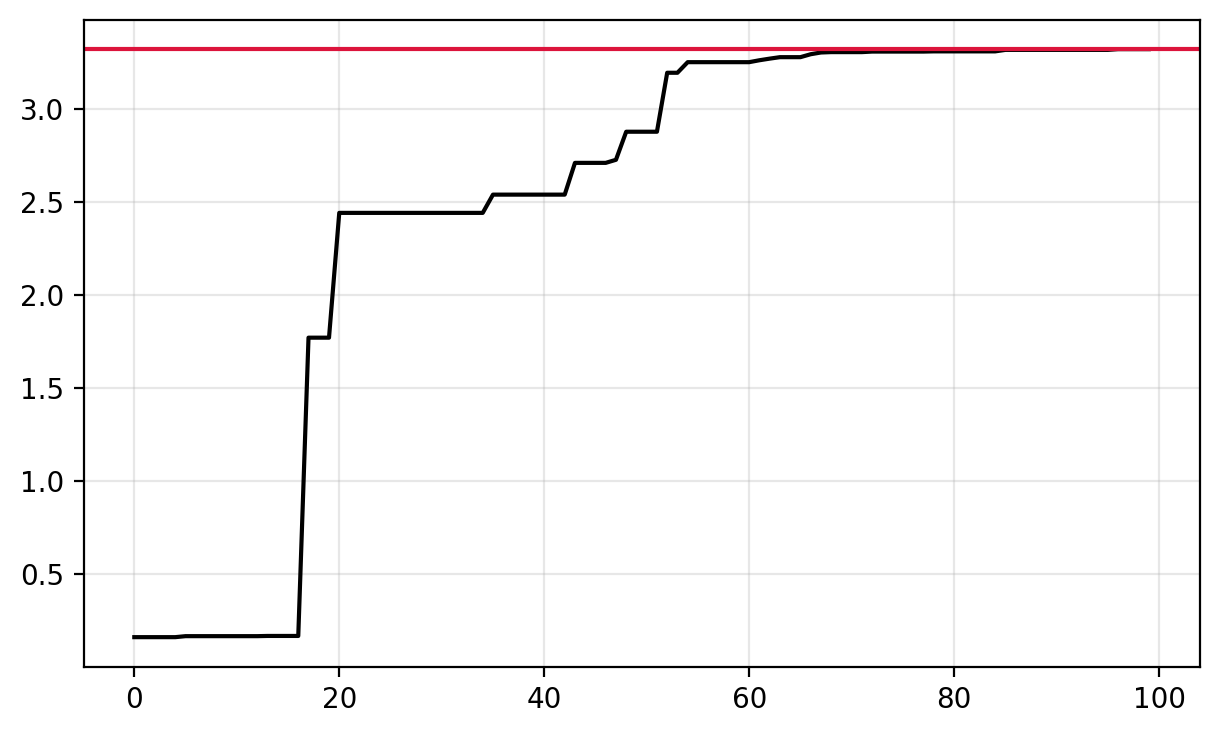

In [178]:
plt.plot(hist["y_best"], c="black")
plt.axhline(y=y_opt, c="crimson")
plt.grid(alpha=0.3)

## Multiple runs

In [319]:
x_opt = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
y_opt = -hartmann6(x_opt)

In [471]:
@partial(jax.jit, static_argnames=("agent", "n_steps",))
@partial(jax.vmap, in_axes=(0, None, None, None, None))
def test_runs(key, agent, n_steps, cov_hidden, cov_last):
    key_init_params, key_init_x, key_eval = jax.random.split(key, 3)

    bel_init = agent.init_bel(
        params_init,
        cov_hidden=cov_hidden, # parameters do not vary much from their initial parameters
        cov_last=cov_last # uncertainty in target
    )

    # W = orthogonal(key_init_params, agent.rank, len(bel_init.mean_hidden))
    # bel_init = bel_init.replace(
    #     loading_hidden=W * cov_hidden
    # )
    
    x_next = jax.random.uniform(key_init_x, shape=(6,), minval=0, maxval=1)
    y_next = hartmann6(x_next)
    
    steps = jnp.arange(n_steps)
    state_init = (bel_init, x_next, y_next, y_next)
    _eval = partial(step, key=key_eval, agent=agent)
    bel_final, hist = jax.lax.scan(_eval, state_init, steps)
    return hist["y_best"]

In [486]:
def plot_hist(ax, runs, color=None, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    color_plot = "black" if color is None else color
    color_fill = "tab:gray" if color is None else color
    
    ax.plot(med_run, c=color_plot, **kwargs)
    ax.fill_between(steps, lbound, ubound, color=color_fill, alpha=0.4)

In [487]:
surrogate = MLP()
params_init = surrogate.init(key_init_params, x_test)

rank = 2
def cov_fn(y): return 0.0
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=rank, dynamics_hidden=0.0, dynamics_last=0.0,
)

In [488]:
%%time
key = jax.random.PRNGKey(314)
keys = jax.random.split(key, 20)
n_steps = 100
cov_hidden = 1e-3
cov_last = 0.5
runs = test_runs(keys, agent, n_steps, cov_hidden, cov_last)
runs = jax.tree.map(np.array, runs)

CPU times: user 16.2 s, sys: 299 ms, total: 16.5 s
Wall time: 8.32 s


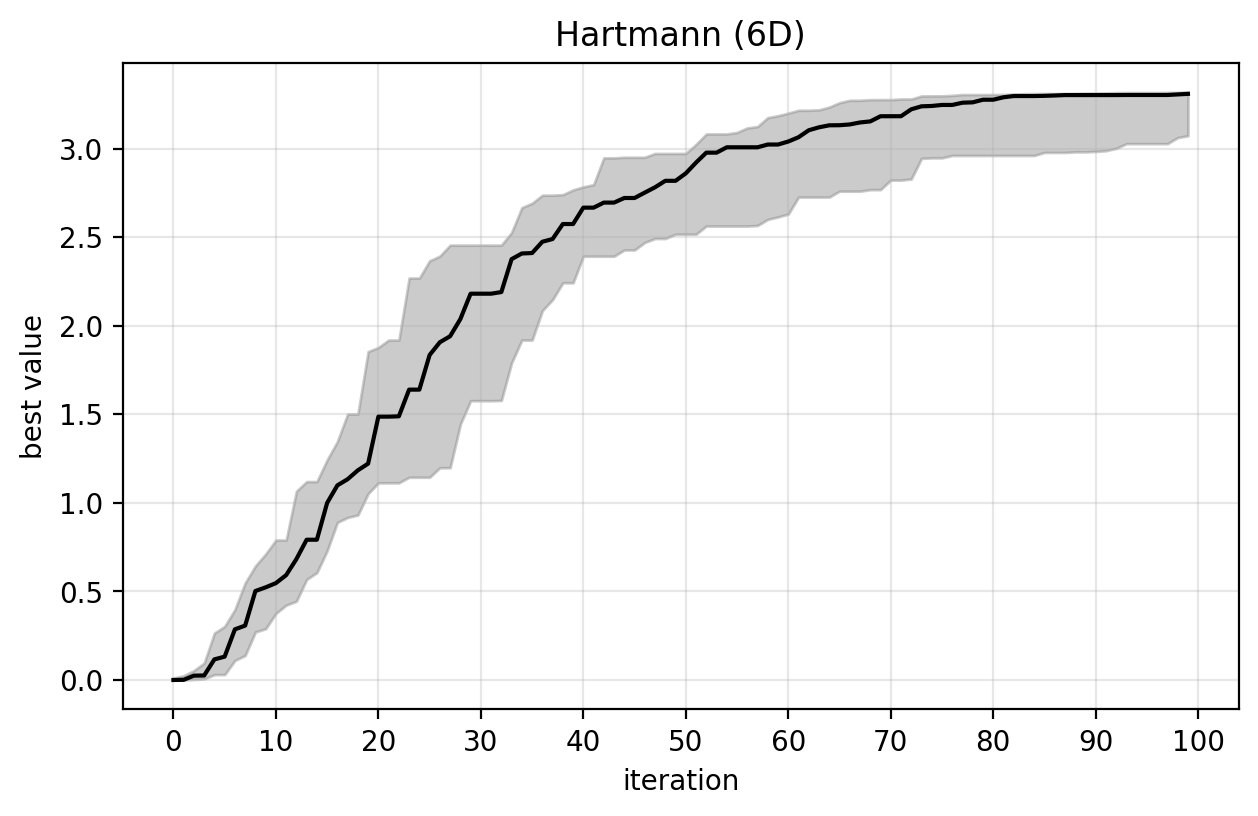

In [489]:
fig, ax = plt.subplots()
plot_hist(ax, runs)
plt.grid(alpha=0.3)
plt.title("Hartmann (6D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.xticks(np.arange(0, 110, 10));

## Varying last-layer prior uncertainty

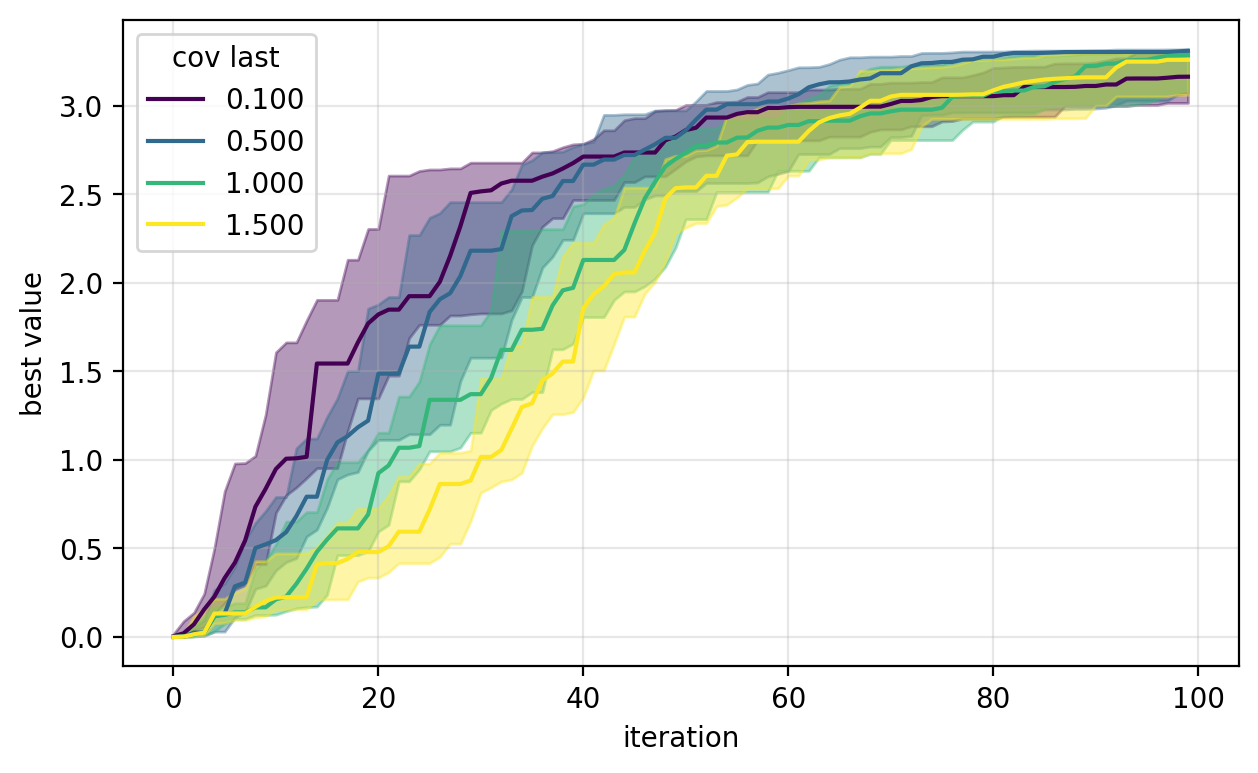

In [491]:
noise_terms = [0.1, 0.5, 1.0, 1.5]
colors = plt.cm.viridis(np.linspace(0, 1, len(noise_terms)))
fig, ax = plt.subplots()
for color, noise in zip(colors, noise_terms):
    runs = test_runs(keys, agent, n_steps, 1e-3, noise)
    runs = jax.tree.map(np.array, runs)
    plot_hist(ax, runs, color=color, label=format(noise, "0.3f"))
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend(title="cov last")
plt.grid(alpha=0.3)

## Varying hidden-layers uncertainty

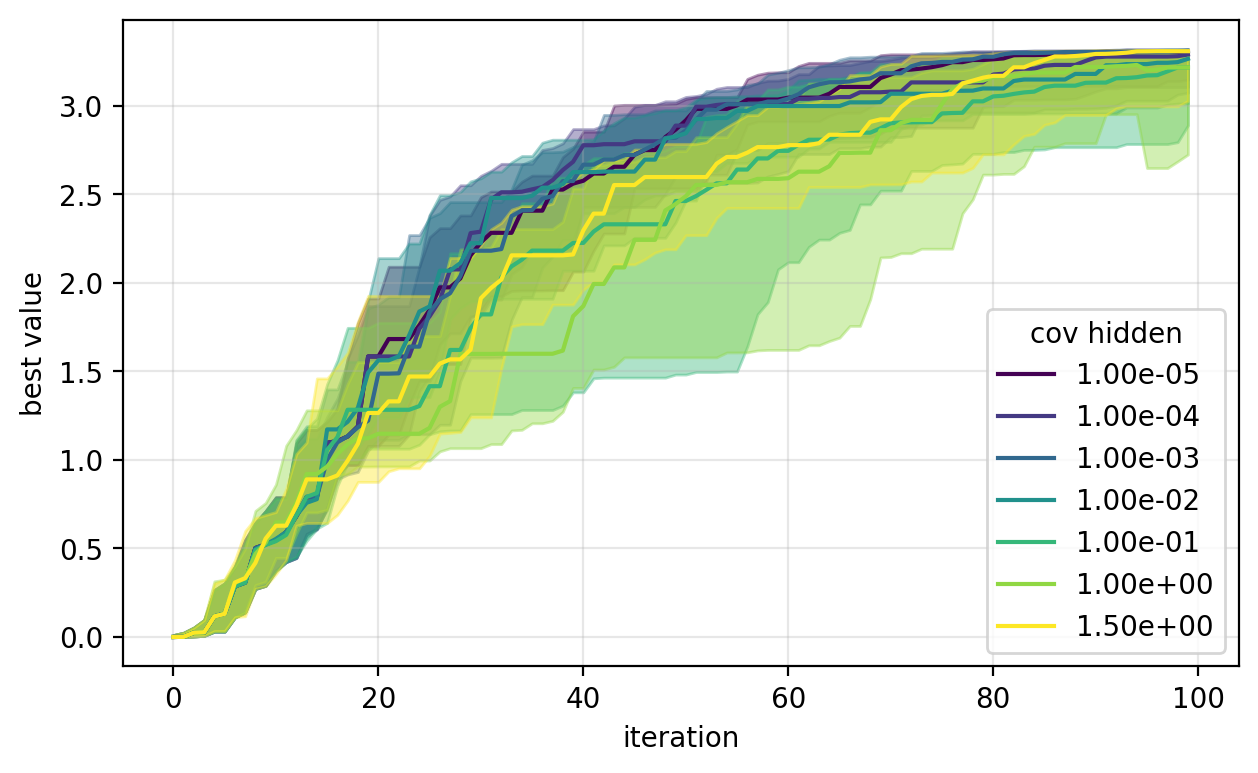

In [492]:
noise_terms = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 1.5]
colors = plt.cm.viridis(np.linspace(0, 1, len(noise_terms)))
fig, ax = plt.subplots()
for color, cov_hidden in zip(colors, noise_terms):
    runs = test_runs(keys, agent, n_steps, cov_hidden, 0.5)
    runs = jax.tree.map(np.array, runs)
    plot_hist(ax, runs, color=color, label=format(cov_hidden, "0.2e"))
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend(title="cov hidden")
plt.grid(alpha=0.3)

## Varying rank

CPU times: user 42.3 s, sys: 940 ms, total: 43.3 s
Wall time: 24.9 s


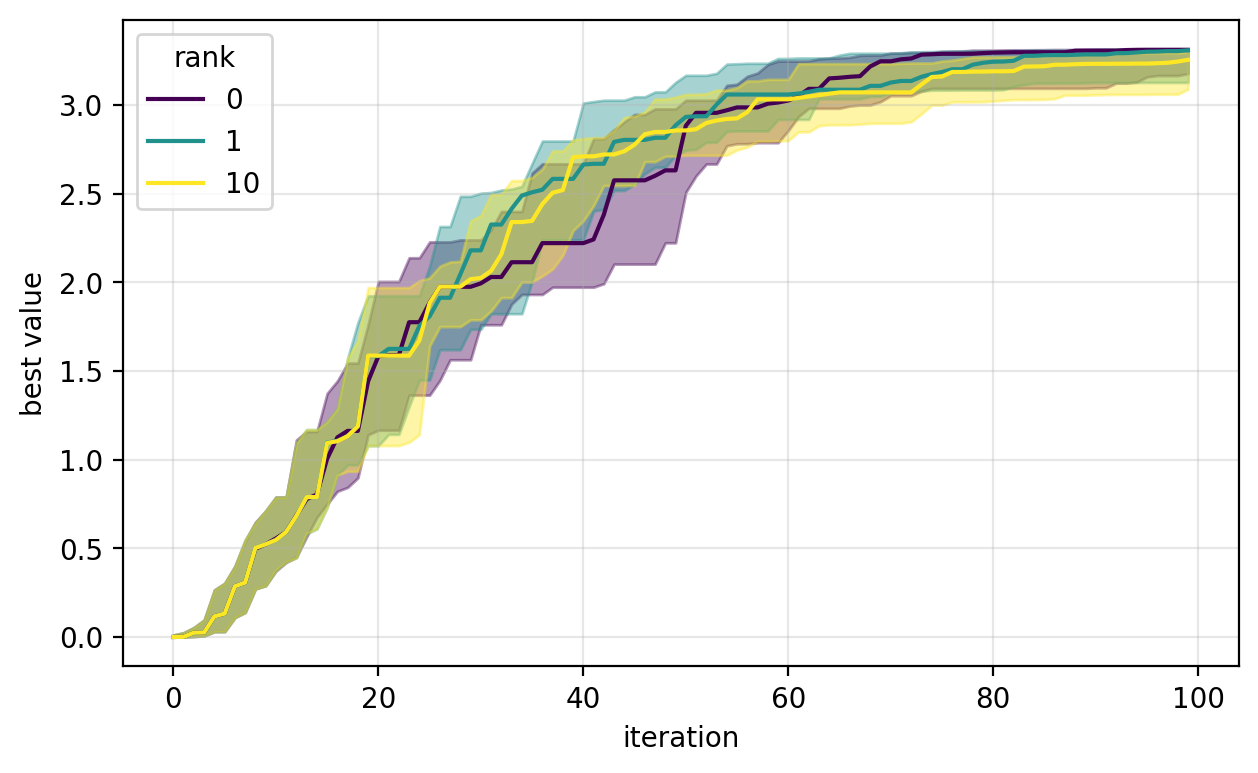

In [493]:
%%time
ranks = [0, 1, 10]
colors = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
fig, ax = plt.subplots()

cov_hidden = 1e-4
cov_last = 0.5
def cov_fn(y): return 0.0

for color, rank in zip(colors, ranks):
    print(f"{rank=:03}", end="\r")
    agent = lrll.LowRankLastLayer(
        surrogate.apply, cov_fn, rank=rank, dynamics_hidden=0.0, dynamics_last=0.0,
    )

    runs = test_runs(keys, agent, n_steps, cov_hidden, cov_last)
    runs = jax.tree.map(np.array, runs)
    plot_hist(ax, runs, color=color, label=rank)
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend(title="rank")
plt.grid(alpha=0.3)